In [15]:
import numpy as np
import seaborn as sns
import pandas as pd

from itertools import groupby
def fasta_iter(fastafile):
    fh = open(fastafile)
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    for header in faiter:
        header = next(header)[1:].strip()
        seq = "".join(s.strip() for s in next(faiter))
        yield header, seq
        
max50fa = {}
for fa in fasta_iter('benchmark/max50.fa'):
    max50fa[fa[0]]=fa[1]

def load(fpath):
    with open(fpath,'r') as f:
        score = []
        real = []
        query = []
        hom = []
        for l in f:
            l = l.rstrip().split()
            query.append(l[0])
            hom.append(l[1])
            score.append(-float(l[2]))
            real.append(float(l[3]))
        return query,hom,score,real
    
def createDF(query,hom,allr,r,thr):
    lst = []
    for i in range(len(allr)):
        d = -allr[i]
        l = r[i]
        if l == 1: label = 'Homolog'
        else: label = 'Non-Homolog'
        if (l==1 and d < thr) or (l==0 and d >= thr): typ = True
        else: typ = False
        lst.append([label,typ,query[i],hom[i],d,int(abs(len(max50fa[query[i]])-len(max50fa[hom[i]])))])

    return pd.DataFrame(lst, columns=['Label','Prediction','Prot1','Prot2','Dist','Protein Pair Size Difference'])

def fetchResults(l1,n1,m1,l2,n2,m2,thr):
    q,h,allr1,r = load('layer/results/allr.%d.%d.%d.res'%(l1,n1,m1))
    q,h,allr2,r = load('layer/results/allr.%d.%d.%d.res'%(l2,n2,m2))
    allr = (np.array(allr1)+np.array(allr2))/2
    print(r[0],r[-1])
    return createDF(q,h,allr,r,thr)
        
thr = 6828.5 #homolog threshold for prost-s
df=fetchResults(25,5,44,13,3,85,thr)
print(df.head())
print(df.tail())

1.0 0.0
     Label  Prediction   Prot1   Prot2    Dist  Protein Pair Size Difference
0  Homolog        True  Q9VFJ2  P53875  4598.0                            38
1  Homolog        True  Q9VFJ2  Q9LFH5  5151.5                            30
2  Homolog        True  Q9VFJ2  Q54J50  4924.5                            30
3  Homolog        True  Q9VFJ2  O29712  4745.0                            39
4  Homolog        True  Q9VFJ2  Q9Y3B7  2861.0                             4
             Label  Prediction   Prot1   Prot2    Dist  \
31891  Non-Homolog        True  Q39212  P01871  7550.5   
31892  Non-Homolog        True  O28385  Q16654  7721.5   
31893  Non-Homolog        True  Q641F1  Q9FNM2  7227.5   
31894  Non-Homolog        True  Q9HBI0  P50107  6932.5   
31895  Non-Homolog        True  P19366  Q5B4H8  7735.5   

       Protein Pair Size Difference  
31891                           134  
31892                           317  
31893                            78  
31894                        

1032 15741 207 14916 1239 0.9611550037622273


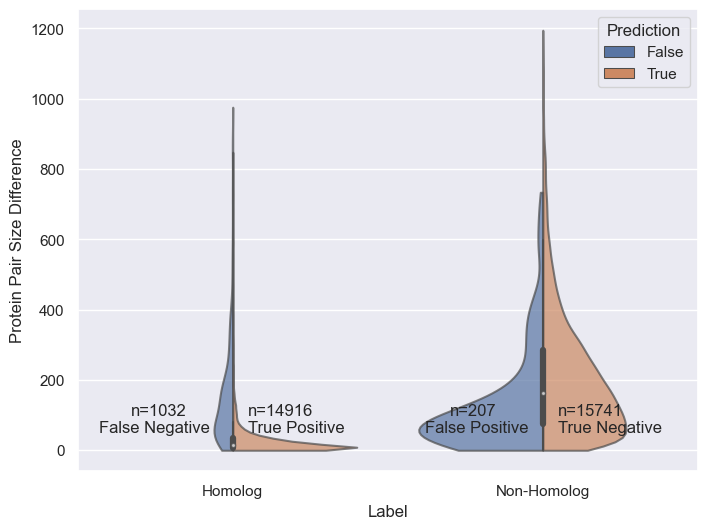

In [14]:
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(8,6)})
t='Homolog & Non-Homolog protein pairs size difference (N=%d pair, Thr=%d)'%(len(df),thr)
ax = sns.violinplot(x="Label", y="Protein Pair Size Difference", hue="Prediction",
                    data=df,cut=0,scale='area',split=True)#.set(title=t)

fp = df[(df['Label'] == 'Non-Homolog') & (df['Prediction'] == False)]['Dist'].count()
tn = df[(df['Label'] == 'Non-Homolog') & (df['Prediction'] == True)]['Dist'].count()
fn = df[(df['Label'] == 'Homolog') & (df['Prediction'] == False)]['Dist'].count()
tp = df[(df['Label'] == 'Homolog') & (df['Prediction'] == True)]['Dist'].count()
print(fn,tn,fp,tp,fp+fn,(tp+tn)/len(df))
ax.text(1.05,100,'n=%d'%tn)
ax.text(1.05,50,'True Negative')
ax.text(.7,100,'n=%d'%fp)
ax.text(.62,50,'False Positive')
ax.text(-.33,100,'n=%d'%fn)
ax.text(-.43,50,'False Negative')
ax.text(.05,100,'n=%d'%tp)
ax.text(0.05,50,'True Positive')
plt.setp(ax.collections, alpha=.7)
plt.savefig('sizeviolin.png', dpi=1200)
plt.savefig('sizeviolin.svg')
plt.show()
#1032 15741 207 14916 1239 0.9611550037622273